In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import savemat # for saving data to .mat file
import sys

In [2]:
# path to functions
sys.path.append(r"/home/illich/SeriesDistance/SeriesDistance Python/functions_Python/")

# import functions
from f_smooth_DP import f_smooth_DP
from f_ReplaceEqualNeighbours import f_ReplaceEqualNeighbours
from f_FindSplitPoints import f_FindSplitPoints
from f_PlotInput import f_PlotInput
from f_CoarseGraining_SD_Continuous import f_CoarseGraining_SD_Continuous

original obs: var: 69.171188618656, # extremes: 1990, diff(obs)=3408.547
original sim: var: 52.86143165392219, # extremes: 500, diff(sim)=2680.4173
smoothed obs: var: 69.171188618656, # extremes: 1990, diff(obs)=3408.547
smoothed sim: var: 52.86143165392219, # extremes: 500, diff(sim)=2680.4173


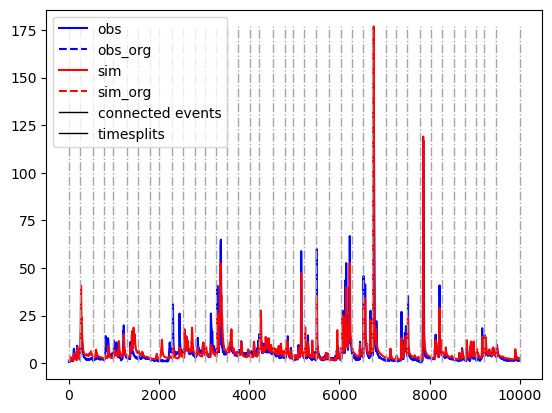

time series split 0 of 39
{'starttime_local': 1, 'endtime_local': 39, 'starttime_global': np.int64(0), 'endtime_global': np.int64(38), 'length': 38, 'rel_length': 0.15833333333333333, 'sum_dQ': np.float64(1.3929999999999998), 'rel_dQ': np.float64(0.06367018220960521), 'relevance': np.float64(0.12500608500547944)}


ValueError: f_AggregateSegment: more than 2 segments left: cannot erase the first or last segment!

In [3]:
# Start from scratch
os.system('clear') # for linux and macOS
# os.system('cls') # for windows
# plt.close('all') # close all figures

# specify paths and parameters, read inputs
# os.chdir('ADD_YOUR_PATH_HERE')  # set working directory

########################################################### mein Working Directory ###########################################################
os.chdir(r"/home/illich/SeriesDistance/")
########################################################### mein Working Directory ###########################################################

# read input
obs = np.genfromtxt('data/HOST_timeseries.csv', delimiter=';', skip_header=1, usecols=2, max_rows=10000)
sim = np.genfromtxt('data/HOST_timeseries.csv', delimiter=';', skip_header=1, usecols=3, max_rows=10000)

# output filenames
outfile = './results/output.mat'

# smoothing options
smooth_flag = True         # smooth both obs and sim (default=True)
nse_smooth_limit = 0.99    # specifies degree of smoothing according to NSE criterion (default=0.99)

# specification of the magnitude error model
error_model = 'relative'  # 'relative' or 'standard'; (default='relative')

# options for time series splitting:
timeseries_split_by_user = False  # 'true': time series splits provided by user in ascii file. 'false': splits will be placed by the program (default=False)
split_frequency = 250             # only required if timeseries_split_by_user=False: this is the default distance between 2 splits (default=500)

# parametrization of the objective function 
weight_nfc = 1/7   # weights number of re-assigned hydrological cases (default= 1)    
weight_rds = 1/7   # weights the importance of the re-assigned segments (default=1) 
weight_sdt = 5/7   # weights the SD timing error component (default=5)
weight_sdv = 0     # weights the SD magnitude error component (default=0)

# set plot flags 
pf_input = True                   # plots input time series ('obs' and 'sim')
pf_segs_cons_entireTS = True      # plots obs, sim, colour-coded pairs of matching segments, SeriesDistance connectors for the entire time series
pf_errordist = True               # plots SeriesDistance error distributions 

# Data manipulations and pre-processing

# smooth if required (default=True)
if smooth_flag:
    obs_org = obs.copy()
    sim_org = sim.copy()
    obs, sim = f_smooth_DP(obs, sim, nse_smooth_limit)

# replace identical neighbouring values to avoid problems with assignment of unique peaks and valleys
obs = f_ReplaceEqualNeighbours(obs)
sim = f_ReplaceEqualNeighbours(sim)

# Define time series split points to improve coarse-graining performance
if not timeseries_split_by_user:
    timeseries_splits = f_FindSplitPoints(obs[0], sim[0], split_frequency)  # find split points if they are not provided by the user       
else:
    timeseries_splits = np.genfromtxt('data/HOST_ts_splits.csv', delimiter=';')  # read splits defined by user.

# plot input data
if pf_input:
    f_PlotInput([], obs, [], [], sim, [], [], timeseries_splits)  # show time series splits

# cleanup
del smooth_flag, nse_smooth_limit, pf_input, timeseries_split_by_user, split_frequency

# Apply coarse-graining and the SD method to the entire time series 
# note: contrary to the event based method both, the coarse-graining and the SD calculation 
# take place in the same function here due to the splitting of the time series. To this end 
# the splitting is solved in a simplistic way and does not support separating the 
# coarse-graining and SD calculation as in the event-based version.

# apply coarse graining and SD calculation: determines optimal level of segment aggregation for entire time series and applies SD to it
segs_obs_opt_all, segs_sim_opt_all, connectors, e_sd_t_all, e_sd_q_all = f_CoarseGraining_SD_Continuous(
    obs, sim, timeseries_splits, weight_nfc, weight_rds, weight_sdt, weight_sdv, error_model)

# plot time series with optimized segments and connectors in an own figure
if pf_segs_cons_entireTS:
    f_PlotConnectedSeries(obs, segs_obs_opt_all, sim, segs_sim_opt_all, connectors)

# plot 2d-error distributions
if pf_errordist:
    f_PlotSDErrors_OnePanel(e_sd_t_all, e_sd_q_all)

# save output
savemat(outfile, {
    'obs': obs,
    'sim': sim,
    'segs_obs_opt_all': segs_obs_opt_all,
    'segs_sim_opt_all': segs_sim_opt_all,
    'connectors': connectors,
    'e_sd_t_all': e_sd_t_all,
    'e_sd_q_all': e_sd_q_all,
    'weight_nfc': weight_nfc,
    'weight_rds': weight_rds,
    'weight_sdt': weight_sdt,
    'weight_sdv': weight_sdv,
    'error_model': error_model
})